<a href="https://colab.research.google.com/github/longxuyi/Stanford/blob/main/AA274A/RRT_STAR_MIDTERM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import numpy as np
import matplotlib.pyplot as plt

def plot_line_segments(ax, segments, **kwargs):
    ax.plot([x for tup in [(p1[0], p2[0], None) for (p1, p2) in segments] for x in tup],
             [y for tup in [(p1[1], p2[1], None) for (p1, p2) in segments] for y in tup], **kwargs)

def line_line_intersection(l1, l2):
    """Checks whether or not two 2D line segments `l1` and `l2` intersect.

    Args:
        l1: A line segment in 2D, i.e., an array-like of two points `((x_start, y_start), (x_end, y_end))`.
        l2: A line segment in 2D, i.e., an array-like of two points `((x_start, y_start), (x_end, y_end))`.

    Returns:
        `True` iff `l1` and `l2` intersect.
    """

    def ccw(A, B, C):
        return np.cross(B - A, C - A) > 0

    A, B = np.array(l1)
    C, D = np.array(l2)
    return ccw(A, C, D) != ccw(B, C, D) and ccw(A, B, C) != ccw(A, B, D)

def plot_rrt(ax, rrt_obj):
    rrt_obj.plot_problem(ax)
    rrt_obj.plot_tree(ax, rrt_obj.Vf, rrt_obj.Pf, color="cornflowerblue", linewidth=0.5, label="RRT tree", zorder=0)
    rrt_obj.plot_path(ax, color="green", linewidth=2, label="Solution path", zorder=5)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.03), fancybox=True, ncol=3)
    ax.scatter(rrt.Vf[:, 0], rrt.Vf[:, 1], zorder=3, color="cornflowerblue")

class RRT(object):
    """ Represents a motion planning problem to be solved using the RRT algorithm"""
    def __init__(self, statespace_lo, statespace_hi, x_init, x_goal, obstacles):
        self.statespace_lo = np.array(statespace_lo)    # state space lower bound (e.g., [-5, -5])
        self.statespace_hi = np.array(statespace_hi)    # state space upper bound (e.g., [5, 5])
        self.x_init = np.array(x_init)                  # initial state
        self.x_goal = np.array(x_goal)                  # goal state
        self.obstacles = obstacles                      # obstacle set (line segments)
        self.path = None        # the final path as a list of states

    def is_free_motion(self, obstacles, x1, x2):
        """
        Subject to the robot dynamics, returns whether a point robot moving
        along the shortest path from x1 to x2 would collide with any obstacles
        (implemented as a "black box")

        Inputs:
            obstacles: list/np.array of line segments ("walls")
            x1: start state of motion
            x2: end state of motion
        Output:
            Boolean True/False
        """
        motion = np.array([x1, x2])
        for line in obstacles:
            if line_line_intersection(motion, line):
                return False
        return True


    def find_nearest(self, V, x):
        """
        Given a list of states V and a query state x, returns the index (row)
        of V such that the steering distance (subject to robot dynamics) from
        V[i] to x is minimized

        Inputs:
            V: list/np.array of states ("samples")
            x - query state
        Output:
            Integer index of nearest point in V to x
        """
        return np.argmin(np.linalg.norm(x - V, axis=1))

    def steer_towards(self, x1, x2, eps):
        """
        Steers from x1 towards x2 along the shortest path (subject to robot
        dynamics). Returns x2 if the length of this shortest path is less than
        eps, otherwise returns the point at distance eps along the path from
        x1 to x2.

        Inputs:
            x1: start state
            x2: target state
            eps: maximum steering distance
        Output:
            State (numpy vector) resulting from bounded steering
        """
        return x1 + (x2 - x1)*min(eps/np.linalg.norm(x2 - x1), 1)

    def solve(self, eps, max_iters=1000, goal_bias=0.05):
        """
        Constructs an RRT rooted at self.x_init with the aim of producing a
        dynamically-feasible and obstacle-free trajectory from self.x_init
        to self.x_goal.

        Inputs:
            eps: maximum steering distance
            max_iters: maximum number of RRT iterations (early termination
                is possible when a feasible solution is found)
            goal_bias: probability during each iteration of setting
                x_rand = self.x_goal (instead of uniformly randly sampling
                from the state space)
        Output:
            None officially (just plots), but see the "Intermediate Outputs"
            descriptions below
        """

        state_dim = len(self.x_init)
        V = np.zeros((max_iters + 1, state_dim))
        V[0,:] = self.x_init
        n = 1
        P = -np.ones(max_iters + 1, dtype=int)

        # Reference code for RRT
        success = False
        for i in range(max_iters):
            if np.random.rand() < goal_bias:
                x = self.x_goal
            else:
                x = self.statespace_lo + np.random.rand(state_dim)*(self.statespace_hi - self.statespace_lo)
            nn_idx = self.find_nearest(V[:n,:], x)
            x_near = V[nn_idx,:]
            x_new = self.steer_towards(x_near, x, eps)
            if self.is_free_motion(self.obstacles, x_near, x_new):
                V[n,:] = x_new
                P[n] = nn_idx
                n = n + 1
                if (x_new == self.x_goal).all():
                    success = True
                    break

        if success:
            solution_idxs = [n-1]
            while P[solution_idxs[0]] != -1:
                solution_idxs.insert(0, P[solution_idxs[0]])
            self.path = V[solution_idxs,:]

        self.Vf = V[:n, :]
        self.Pf = P[:n]

        return success

    def plot_problem(self, ax):
        plot_line_segments(ax, self.obstacles, color="red", linewidth=2, label="obstacles", zorder=10)
        ax.scatter([self.x_init[0], self.x_goal[0]], [self.x_init[1], self.x_goal[1]], color="green", s=30, zorder=10)
        ax.annotate(r"$x_{init}$", self.x_init[:2] + [.2, 0], fontsize=16)
        ax.annotate(r"$x_{goal}$", self.x_goal[:2] + [.2, 0], fontsize=16)
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.03), fancybox=True, ncol=3)
        ax.axis('scaled')

    def plot_tree(self, ax, V, P, **kwargs):
        plot_line_segments(ax, [(V[P[i],:], V[i,:]) for i in range(V.shape[0]) if P[i] >= 0], **kwargs)

    def plot_path(self, ax, **kwargs):
        path = np.array(self.path)
        ax.plot(path[:,0], path[:,1], **kwargs)

In [11]:
class RRTStar(RRT):
    def solve(self, eps, max_iters=1000, goal_bias=0.05):
        """
        Constructs an RRT rooted at self.x_init with the aim of producing a
        dynamically-feasible and obstacle-free trajectory from self.x_init
        to self.x_goal.

        Inputs:
            eps: maximum steering distance
            max_iters: maximum number of RRT iterations (early termination
                is possible when a feasible solution is found)
            goal_bias: probability during each iteration of setting
                x_rand = self.x_goal (instead of uniformly randomly sampling
                from the state space)
        Output:
            None officially (just plots), but see the "Intermediate Outputs"
            descriptions below
        """

        state_dim = len(self.x_init)

        # V stores the states that have been added to the RRT (pre-allocated at its maximum size
        # since numpy doesn't play that well with appending/extending)
        V = np.zeros((max_iters + 1, state_dim))
        V[0,:] = self.x_init    # RRT is rooted at self.x_init
        n = 1                   # the current size of the RRT (states accessible as V[range(n),:])

        # P stores the parent of each state in the RRT. P[0] = -1 since the root has no parent,
        # P[1] = 0 since the parent of the first additional state added to the RRT must have been
        # extended from the root, in general 0 <= P[i] < i for all i < n
        P = -np.ones(max_iters + 1, dtype=int)

        # New variables for RRT*
        C = np.zeros((max_iters + 1,)) # "Cost" of each node
        radius = 2.0                   # RRT* neighbor radius

        success = False

        ## Intermediate Outputs
        # You must update and/or populate:
        #    - V, P, n: the represention of the planning tree
        #    - C: Cost of each node (length of path to initial x)
        #    - success: whether or not you've found a solution within max_iters RRT iterations
        #    - self.path: if success is True, then must contain list of states (tree nodes)
        #          [x_init, ..., x_goal] such that the global trajectory made by linking steering
        #          trajectories connecting the states in order is obstacle-free.

        for i in range(max_iters):
            if np.random.rand() < goal_bias:
                x = self.x_goal
            else:
                x = self.statespace_lo + np.random.rand(state_dim)*(self.statespace_hi - self.statespace_lo)
            nn_idx = self.find_nearest(V[:n,:], x)
            x_near = V[nn_idx,:]
            x_new = self.steer_towards(x_near, x, eps)
            if self.is_free_motion(self.obstacles, x_near, x_new):
                # Remember you ONLY need to edit code insde of these bounds!
                # -------------- NEW CODE STARTS ---------------------
                x_neighbors = [x for x in V if np.linalg.norm(x - x_new) < radius]
                c_min = C[nn_idx] + np.linalg.norm(x_new - x_near)
                x_best = x_near

                for x in x_neighbors:
                  nn_idx = np.where(V[range(n),:] == x)[0][0]
                  c = C[nn_idx] + np.linalg.norm(x - x_new)

                  if self.is_free_motion(self.obstacles, x, x_new) and c < c_min:
                    c_min = c
                    x_best = x

                V[n,:] =x_new
                P[n] = np.where(V[range(n),:] == x_best)[0][0]
                C[n]= c_min

                for x in x_neighbors:
                  nn_idx = np.where(V[range(n),:] == x)[0][0]
                  c = c_min + np.linalg.norm(x - x_new)

                  if self.is_free_motion(self.obstacles, x, x_new) and c < C[nn_idx]:
                    P[n] = nn_idx
                    C[nn_idx] = c

                # -------------- NEW CODE ENDS ---------------------

                n = n + 1
                if (x_new == self.x_goal).all():
                    success = True
                    break

        # Extract the solution path from the tree.
        if success:
            solution_idxs = [n-1]
            while P[solution_idxs[0]] != -1:
                solution_idxs.insert(0, P[solution_idxs[0]])
            self.path = V[solution_idxs,:]

        # Variables for plotting
        self.Vf = V[:n, :]
        self.Pf = P[:n]

        return success

In [12]:
MAZE = np.array([
    ((10,10), ( 0,10)),
    (( 0,10), ( 0, 0)),
    (( 0, 0), (10, 0)),
    ((10, 0), (10,10)),
    (( 4, 3), ( 4, 2)),
    (( 4, 3), ( 2, 3)),
    (( 2, 2), ( 2, 3)),
    (( 2, 2), ( 4, 2)),
    (( 8, 8), ( 6, 8)),
    (( 8, 8), ( 8, 7)),
    (( 6, 7), ( 6, 8)),
    (( 6, 7), ( 8, 7)),
    (( 8, 5), ( 6, 5)),
    (( 8, 5), ( 8, 3)),
    (( 6, 3), ( 6, 5)),
    (( 6, 3), ( 8, 3)),
    (( 4, 7), ( 4, 5)),
    (( 4, 7), ( 2, 7)),
    (( 2, 5), ( 2, 7)),
    (( 2, 5), ( 4, 5))
])

# try changing these!
x_init = [1,9] # reset to [1,9] when saving results for submission
x_goal = [9,1] # reset to [9,1] when saving results for submission

Text(0.5, 1.0, 'RRT*')

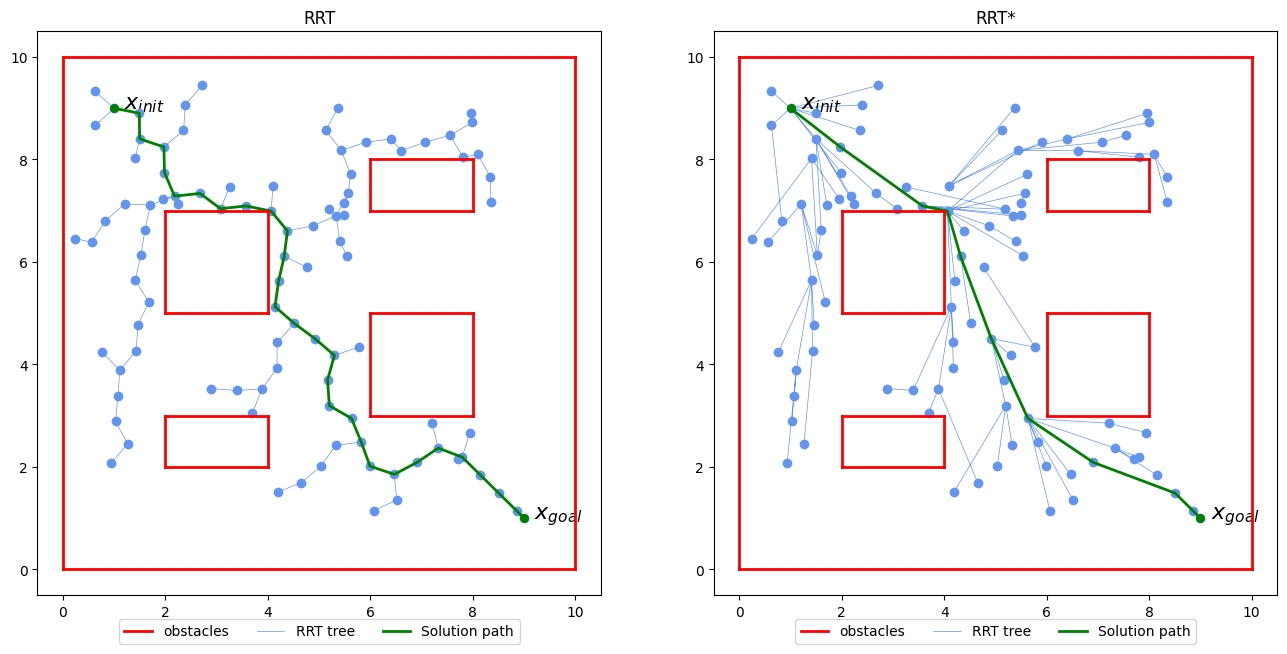

In [14]:
# Run Vanilla RRT
np.random.seed(42)
rrt = RRT([0,0], [10,10], x_init, x_goal, MAZE)
success = rrt.solve(0.5, 500)

# Run RRT*
np.random.seed(42)
rrtstar = RRTStar([0,0], [10,10], x_init, x_goal, MAZE)
success = rrtstar.solve(0.5, 500)

# Plot results side by side
fig, axs = plt.subplots(ncols=2, figsize=(16, 8))
plot_rrt(axs[0], rrt)
axs[0].set_title("RRT")
plot_rrt(axs[1], rrtstar)
axs[1].set_title("RRT*")


In [2]:
!git push

usage: git [--version] [--help] [-C <path>] [-c <name>=<value>]
           [--exec-path[=<path>]] [--html-path] [--man-path] [--info-path]
           [-p | --paginate | -P | --no-pager] [--no-replace-objects] [--bare]
           [--git-dir=<path>] [--work-tree=<path>] [--namespace=<name>]
           [--super-prefix=<path>] [--config-env=<name>=<envvar>]
           <command> [<args>]

These are common Git commands used in various situations:

start a working area (see also: git help tutorial)
   clone     Clone a repository into a new directory
   init      Create an empty Git repository or reinitialize an existing one

work on the current change (see also: git help everyday)
   add       Add file contents to the index
   mv        Move or rename a file, a directory, or a symlink
   restore   Restore working tree files
   rm        Remove files from the working tree and from the index

examine the history and state (see also: git help revisions)
   bisect    Use binary search to find th